![alt text](logo2.png "Title")

# Sentiment Analysis on movie reviews

Análisis de sentimiento mediante Recurrent Neural Networs usando el dataset publicado en http://ai.stanford.edu/~amaas/data/sentiment/ y procesado en un único .csv por https://www.kaggle.com/utathya/imdb-review-dataset

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
data = pd.read_csv("imdb_master.csv", encoding='latin-1', index_col = 0)
data.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
data_labeled = data[data.label != 'unsup']
del data

In [4]:
print("Número total de reviews --> ",len(data_labeled))
print("Número total de reviews positivas --> ",len(data_labeled[data_labeled["label"]=='pos']))
print("Número total de reviews negativas --> ",len(data_labeled[data_labeled["label"]=='neg']))

Número total de reviews -->  50000
Número total de reviews positivas -->  25000
Número total de reviews negativas -->  25000


In [5]:
y=data_labeled['label'].apply(lambda x: 0 if x == 'neg' else 1)

## Entrenamiento con 7500 reviews

Dividiremos el conjunto data_labeled en dos conjuntos, uno large y otro small. Ahora entrenaremos el modelos con un conjunto de 7500 reviews y reservaremos 2500 como test data set.

In [6]:
from sklearn.model_selection import train_test_split

#Aislamos nuestro conjunto de test y de train
reviews_large, reviews_test, y_large, y_test = train_test_split(data_labeled['review'], y, test_size=2500, stratify=y)

#Extraemos un subconjunto de entrenamiento de solo 7500 reviews
reviews_rest, reviews_train, y_rest, y_train = train_test_split(reviews_large, y_large, test_size=7500, stratify=y_large)

#### Procesamiento de texto 

In [7]:
import keras

C:\Users\Alfonso.arias\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
max_dic = 1000 #Número máximo de palabras que tendrá nuestro diccionario.

#El Tokenizer de Keras nos permite quedarnos con las palabras más frecuentes de todas las reviews
diccionario = keras.preprocessing.text.Tokenizer(num_words = max_dic)
diccionario.fit_on_texts(reviews_train)
#Ahora, por cada review obtenemos un vector de enteros indicando la palabra del diccionario
X_train = diccionario.texts_to_sequences(reviews_train)

#Realizamos lo mismo para el data set de test
X_test = diccionario.texts_to_sequences(reviews_test)

In [9]:
#Es recomendable que todas las reviews tengan la misma extensión de palabras
max_palabras=300
X_train=keras.preprocessing.sequence.pad_sequences(X_train,maxlen=max_palabras)
X_test=keras.preprocessing.sequence.pad_sequences(X_test,maxlen=max_palabras)

#### Estructuras RNN

In [10]:
red_neuronal=keras.models.Sequential()

#Primera capa tipo embedding. Creamos un embedding de dimensión 64
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))

#Segunda capa tipo LSTM con 32 neuronas. Devuelve un vector después de procesar la secuencia completa
red_neuronal.add(keras.layers.recurrent.LSTM(32))

#Última capa que devuelve un valor entre 0 y 1
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))

red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [11]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
startTime = datetime.now()
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5446 - acc: 0.7139
Epoch 2/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.3916 - acc: 0.8317
Epoch 3/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.3557 - acc: 0.8513
Epoch 4/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.3301 - acc: 0.8647
Epoch 5/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.2760 - acc: 0.8881


In [13]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=pd.DataFrame({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time },index=['LSTM-1hl'])
print(df)

2500/2500 [==============================] - 2s 881us/step
Test loss 0.36444859922528267
Test accuracy 0.8364
          testAccuracy  testLoss  trainAccuracy  trainLoss       trainTime
LSTM-1hl        0.8364  0.364449       0.888133   0.275954 00:02:27.162798


Observamos que la precisión de nuestro conjunto de entrenamiento es mucho mayor que la de nuestro conjunto de test. Para solucionarlo, usaremos Dropout

In [14]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [15]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
7500/7500 [==============================] - 34s 4ms/step - loss: 0.5906 - acc: 0.6856
Epoch 2/5
7500/7500 [==============================] - 33s 4ms/step - loss: 0.4534 - acc: 0.7989
Epoch 3/5
7500/7500 [==============================] - 33s 4ms/step - loss: 0.4373 - acc: 0.8027
Epoch 4/5
7500/7500 [==============================] - 34s 4ms/step - loss: 0.4169 - acc: 0.8189
Epoch 5/5
7500/7500 [==============================] - 33s 4ms/step - loss: 0.3927 - acc: 0.8284


In [16]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='LSTM-1hl-drop'))
print(df)

2500/2500 [==============================] - 2s 986us/step
Test loss 0.43476067386865613
Test accuracy 0.8088
               testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl             0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop        0.8088  0.434761       0.828400   0.392736   

                    trainTime  
LSTM-1hl      00:02:27.162798  
LSTM-1hl-drop 00:02:48.225743  


Observamos que no se obtiene tanto overfitting. Vamos a añadir otro LSTM layer manteniendo los dropout.

In [17]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 32)           12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
_________________________________________________________________


In [18]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
7500/7500 [==============================] - 64s 8ms/step - loss: 0.5693 - acc: 0.6968
Epoch 2/5
7500/7500 [==============================] - 62s 8ms/step - loss: 0.4494 - acc: 0.7997
Epoch 3/5
7500/7500 [==============================] - 62s 8ms/step - loss: 0.4149 - acc: 0.8203
Epoch 4/5
7500/7500 [==============================] - 63s 8ms/step - loss: 0.3927 - acc: 0.8293
Epoch 5/5
7500/7500 [==============================] - 63s 8ms/step - loss: 0.3790 - acc: 0.8428


In [19]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='LSTM-2hl-drop'))
print(df)

2500/2500 [==============================] - 4s 2ms/step
Test loss 0.445003527545929
Test accuracy 0.804
               testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl             0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop        0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop        0.8040  0.445004       0.842800   0.378978   

                    trainTime  
LSTM-1hl      00:02:27.162798  
LSTM-1hl-drop 00:02:48.225743  
LSTM-2hl-drop 00:05:16.154574  


Usaremos ahora BRNN

In [20]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
7500/7500 [==============================] - 63s 8ms/step - loss: 0.6044 - acc: 0.6724
Epoch 2/5
7500/7500 [==============================] - 62s 8ms/step - loss: 0.4637 - acc: 0.7939
Epoch 3/5
7500/7500 [==============================] - 62s 8ms/step - loss: 0.4212 - acc: 0.8151
Epoch 4/5
7500/7500 [==============================] - 62s 8ms/step - loss: 0.4100 - acc: 0.8225
Epoch 5/5
7500/7500 [==============================] - 66s 9ms/step - loss: 0.4131 - acc: 0.8169


In [22]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='BRNN-1hl-drop'))
print(df)

2500/2500 [==============================] - 4s 2ms/step
Test loss 0.4696289874315262
Test accuracy 0.78
               testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl             0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop        0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop        0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop        0.7800  0.469629       0.816933   0.413109   

                    trainTime  
LSTM-1hl      00:02:27.162798  
LSTM-1hl-drop 00:02:48.225743  
LSTM-2hl-drop 00:05:16.154574  
BRNN-1hl-drop 00:05:16.401130  


In [23]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True)))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 64)           24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
_________________________________________________________________


In [24]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
7500/7500 [==============================] - 121s 16ms/step - loss: 0.5592 - acc: 0.7011
Epoch 2/5
7500/7500 [==============================] - 118s 16ms/step - loss: 0.4733 - acc: 0.7809
Epoch 3/5
7500/7500 [==============================] - 119s 16ms/step - loss: 0.4373 - acc: 0.8021
Epoch 4/5
7500/7500 [==============================] - 117s 16ms/step - loss: 0.4057 - acc: 0.8268
Epoch 5/5
7500/7500 [==============================] - 116s 16ms/step - loss: 0.4059 - acc: 0.8213


In [25]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='BRNN-2hl-drop'))
print(df)

2500/2500 [==============================] - 9s 4ms/step
Test loss 0.4378792983055115
Test accuracy 0.8072
               testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl             0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop        0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop        0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop        0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop        0.8072  0.437879       0.821333   0.405872   

                    trainTime  
LSTM-1hl      00:02:27.162798  
LSTM-1hl-drop 00:02:48.225743  
LSTM-2hl-drop 00:05:16.154574  
BRNN-1hl-drop 00:05:16.401130  
BRNN-2hl-drop 00:09:55.164427  


## Entrenamiento con 47500 reviews

In [26]:
#Debemos usar el dataset grande para definir un nuevo diccionario
diccionario_large = keras.preprocessing.text.Tokenizer(num_words = max_dic)
diccionario_large.fit_on_texts(reviews_train)
X_train_large = diccionario_large.texts_to_sequences(reviews_large)
X_test_large = diccionario_large.texts_to_sequences(reviews_test)

In [27]:
max_palabras=300
X_train_large=keras.preprocessing.sequence.pad_sequences(X_train_large,maxlen=max_palabras)
X_test_large=keras.preprocessing.sequence.pad_sequences(X_test_large,maxlen=max_palabras)

In [28]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [29]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 185s 4ms/step - loss: 0.3885 - acc: 0.8256
Epoch 2/5
47500/47500 [==============================] - 184s 4ms/step - loss: 0.3191 - acc: 0.8665
Epoch 3/5
47500/47500 [==============================] - 185s 4ms/step - loss: 0.2970 - acc: 0.8748
Epoch 4/5
47500/47500 [==============================] - 187s 4ms/step - loss: 0.2717 - acc: 0.8874
Epoch 5/5
47500/47500 [==============================] - 186s 4ms/step - loss: 0.2565 - acc: 0.8939


In [30]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-1hl'))
print(df)

2500/2500 [==============================] - 3s 1ms/step
Test loss 0.27968829569518566
Test accuracy 0.8788
                testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl              0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop         0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop         0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop         0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop         0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl        0.8788  0.279688       0.893916   0.256513   

                     trainTime  
LSTM-1hl       00:02:27.162798  
LSTM-1hl-drop  00:02:48.225743  
LSTM-2hl-drop  00:05:16.154574  
BRNN-1hl-drop  00:05:16.401130  
BRNN-2hl-drop  00:09:55.164427  
large-LSTM-1hl 00:15:27.364819  


Añadimos dropout

In [31]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [32]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 214s 5ms/step - loss: 0.4725 - acc: 0.7799
Epoch 2/5
47500/47500 [==============================] - 215s 5ms/step - loss: 0.4139 - acc: 0.8185
Epoch 3/5
47500/47500 [==============================] - 229s 5ms/step - loss: 0.3771 - acc: 0.8392
Epoch 4/5
47500/47500 [==============================] - 214s 5ms/step - loss: 0.3530 - acc: 0.8514
Epoch 5/5
47500/47500 [==============================] - 215s 5ms/step - loss: 0.3595 - acc: 0.8421


In [33]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-1hl-drop'))
print(df)

2500/2500 [==============================] - 3s 1ms/step
Test loss 0.31786349937915803
Test accuracy 0.8612
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   

                          trainTime  
LSTM-1hl            00:02:27.162798  
LSTM-1hl-drop       00:02:48.225743  
LSTM-2hl-drop       00:05:16.154574  
BRNN-1hl-drop       00:05:16.401130  
BRNN-2hl-drop       00:09:55.164427  
large-LSTM-1hl      00:15:27.364819  
large-LSTM-1hl-drop 00:18:08.538732  


RNN con dos capas del tipo LSTM

In [34]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
_________________________________________________________________


In [35]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 411s 9ms/step - loss: 0.4635 - acc: 0.7834
Epoch 2/5
47500/47500 [==============================] - 407s 9ms/step - loss: 0.4189 - acc: 0.8129
Epoch 3/5
47500/47500 [==============================] - 404s 9ms/step - loss: 0.3413 - acc: 0.8585
Epoch 4/5
47500/47500 [==============================] - 403s 8ms/step - loss: 0.3115 - acc: 0.8728
Epoch 5/5
47500/47500 [==============================] - 403s 8ms/step - loss: 0.2916 - acc: 0.8815


In [36]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-2hl-drop'))
print(df)

2500/2500 [==============================] - 5s 2ms/step
Test loss 0.3111357528403401
Test accuracy 0.866
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   

                          trainTime  
LSTM-1hl            00:02:27.162798  
LSTM-1hl-drop       00:02:48.225743  
LSTM-2hl-drop       00:05:16.154574  
BRNN-1hl-drop       00:05:16.401130  
BRNN-2hl-drop       00:09:55.164427  
large-LS

RNN con 3 capas del tipo LSTM

In [37]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_13 (LSTM)               (None, 300, 32)           8320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 93,089
Trainable params: 93,089
Non-trainable params: 0
_________________________________________________________________


In [38]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 578s 12ms/step - loss: 0.4619 - acc: 0.7849
Epoch 2/5
47500/47500 [==============================] - 583s 12ms/step - loss: 0.3848 - acc: 0.8337
Epoch 3/5
47500/47500 [==============================] - 575s 12ms/step - loss: 0.3820 - acc: 0.8357
Epoch 4/5
47500/47500 [==============================] - 584s 12ms/step - loss: 0.3332 - acc: 0.8586
Epoch 5/5
47500/47500 [==============================] - 581s 12ms/step - loss: 0.3172 - acc: 0.8677


In [39]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-3hl-drop'))
print(df)

2500/2500 [==============================] - 7s 3ms/step
Test loss 0.3320368373632431
Test accuracy 0.8516
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   

                          trainTime  
LSTM-1hl            00:02:27.162798  
LSTM-1hl-drop       00:02:48.225743  
LSTM-2hl-drop       00:05:16.154574  
BRNN-1hl-d

BRNN

In [40]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________


In [41]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 410s 9ms/step - loss: 0.4877 - acc: 0.7696
Epoch 2/5
47500/47500 [==============================] - 410s 9ms/step - loss: 0.4475 - acc: 0.7928
Epoch 3/5
47500/47500 [==============================] - 406s 9ms/step - loss: 0.3841 - acc: 0.8312
Epoch 4/5
47500/47500 [==============================] - 404s 9ms/step - loss: 0.3536 - acc: 0.8478
Epoch 5/5
47500/47500 [==============================] - 416s 9ms/step - loss: 0.3797 - acc: 0.8330


In [42]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-BRNN-1hl-drop'))
print(df)

2500/2500 [==============================] - 5s 2ms/step
Test loss 0.38096462206840515
Test accuracy 0.8308
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   

                          trainTime  
LSTM-1hl            00:02:27.162798  
LSTM-1hl-dro

BRNN dos layers

In [43]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3,return_sequences=True)))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.3)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 300, 64)           24832     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
_________________________________________________________________


In [44]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 761s 16ms/step - loss: 0.4838 - acc: 0.7706
Epoch 2/5
47500/47500 [==============================] - 772s 16ms/step - loss: 0.4294 - acc: 0.8075
Epoch 3/5
47500/47500 [==============================] - 806s 17ms/step - loss: 0.3996 - acc: 0.8248
Epoch 4/5
47500/47500 [==============================] - 759s 16ms/step - loss: 0.3383 - acc: 0.8588
Epoch 5/5
47500/47500 [==============================] - 707s 15ms/step - loss: 0.3019 - acc: 0.8737


In [45]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-BRNN-2hl-drop'))
print(df)

2500/2500 [==============================] - 10s 4ms/step
Test loss 0.2969142947256565
Test accuracy 0.862
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   
large-BRNN-2hl-drop        0.8620  0.296914       0.873684   0.301939   

                

Mismos modelos sin dropout

In [46]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,return_sequences=True)))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 300, 64)           24832     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
_________________________________________________________________


In [47]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 692s 15ms/step - loss: 0.3927 - acc: 0.8231
Epoch 2/5
47500/47500 [==============================] - 691s 15ms/step - loss: 0.3127 - acc: 0.8704
Epoch 3/5
47500/47500 [==============================] - 718s 15ms/step - loss: 0.3049 - acc: 0.8727
Epoch 4/5
47500/47500 [==============================] - 727s 15ms/step - loss: 0.2796 - acc: 0.8843
Epoch 5/5
47500/47500 [==============================] - 784s 17ms/step - loss: 0.2611 - acc: 0.8948


In [48]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-BRNN-2hl'))
print(df)

2500/2500 [==============================] - 9s 4ms/step
Test loss 0.2757462933629751
Test accuracy 0.8832
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   
large-BRNN-2hl-drop        0.8620  0.296914       0.873684   0.301939   
large-BRNN-2hl   

In [62]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_15 (Activation)   (None, 1)                 0         
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________


In [63]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 364s 8ms/step - loss: 0.3966 - acc: 0.8195
Epoch 2/5
47500/47500 [==============================] - 357s 8ms/step - loss: 0.3206 - acc: 0.8651
Epoch 3/5
47500/47500 [==============================] - 361s 8ms/step - loss: 0.2983 - acc: 0.8756
Epoch 4/5
47500/47500 [==============================] - 360s 8ms/step - loss: 0.2849 - acc: 0.8826
Epoch 5/5
47500/47500 [==============================] - 359s 8ms/step - loss: 0.2599 - acc: 0.8923


In [64]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-BRNN-1hl'))
print(df)

2500/2500 [==============================] - 5s 2ms/step
Test loss 0.33331746572852133
Test accuracy 0.8516
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   
large-BRNN-2hl-drop        0.8620  0.296914       0.873684   0.301939   
large-BRNN-2hl  

In [65]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
lstm_23 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_16 (Activation)   (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
_________________________________________________________________


In [66]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 348s 7ms/step - loss: 0.3771 - acc: 0.8315
Epoch 2/5
47500/47500 [==============================] - 345s 7ms/step - loss: 0.3173 - acc: 0.8650
Epoch 3/5
47500/47500 [==============================] - 344s 7ms/step - loss: 0.2912 - acc: 0.8798
Epoch 4/5
47500/47500 [==============================] - 342s 7ms/step - loss: 0.2717 - acc: 0.8895
Epoch 5/5
47500/47500 [==============================] - 351s 7ms/step - loss: 0.2584 - acc: 0.8953


In [67]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-2hl'))
print(df)

2500/2500 [==============================] - 5s 2ms/step
Test loss 0.28577697660923
Test accuracy 0.8808
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   
large-BRNN-2hl-drop        0.8620  0.296914       0.873684   0.301939   
large-BRNN-2hl     

In [68]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 64)           64000     
_________________________________________________________________
lstm_25 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_26 (LSTM)               (None, 300, 32)           8320      
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_17 (Activation)   (None, 1)                 0         
Total params: 93,089
Trainable params: 93,089
Non-trainable params: 0
_________________________________________________________________


In [69]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
startTime = datetime.now()
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)
time=datetime.now() - startTime

Epoch 1/5
47500/47500 [==============================] - 527s 11ms/step - loss: 0.3859 - acc: 0.8268
Epoch 2/5
47500/47500 [==============================] - 513s 11ms/step - loss: 0.3143 - acc: 0.8674
Epoch 3/5
47500/47500 [==============================] - 505s 11ms/step - loss: 0.2981 - acc: 0.8756
Epoch 4/5
47500/47500 [==============================] - 510s 11ms/step - loss: 0.2760 - acc: 0.8874
Epoch 5/5
47500/47500 [==============================] - 510s 11ms/step - loss: 0.2682 - acc: 0.8913


In [70]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1],'trainTime':time},name='large-LSTM-3hl'))
print(df)

2500/2500 [==============================] - 7s 3ms/step
Test loss 0.46700787591934206
Test accuracy 0.764
                     testAccuracy  testLoss  trainAccuracy  trainLoss  \
LSTM-1hl                   0.8364  0.364449       0.888133   0.275954   
LSTM-1hl-drop              0.8088  0.434761       0.828400   0.392736   
LSTM-2hl-drop              0.8040  0.445004       0.842800   0.378978   
BRNN-1hl-drop              0.7800  0.469629       0.816933   0.413109   
BRNN-2hl-drop              0.8072  0.437879       0.821333   0.405872   
large-LSTM-1hl             0.8788  0.279688       0.893916   0.256513   
large-LSTM-1hl-drop        0.8612  0.317863       0.842147   0.359524   
large-LSTM-2hl-drop        0.8660  0.311136       0.881474   0.291582   
large-LSTM-3hl-drop        0.8516  0.332037       0.867684   0.317230   
large-BRNN-1hl-drop        0.8308  0.380965       0.833011   0.379739   
large-BRNN-2hl-drop        0.8620  0.296914       0.873684   0.301939   
large-BRNN-2hl   

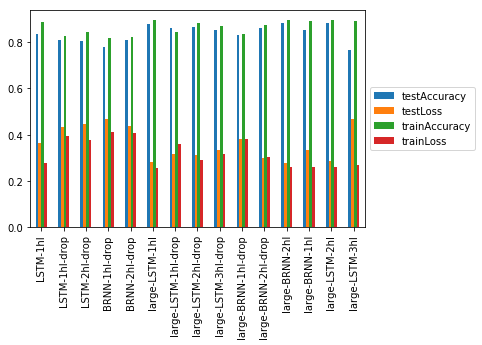

In [71]:
import matplotlib.pyplot as plt
plt.figure()
df.iloc[:,0:4].plot(kind='bar',legend=False).legend(loc='center left', bbox_to_anchor=(1, 0.5))